In [45]:
from read_mem import *
import matplotlib.pyplot as plt
import pathlib

E10A0.01LBFGS10C4Projector
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
E10A0.01LBFGS10Projector
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
E10A0.01LBFGS10
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
E10A0.01LBFGS10C4
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
E5A0.01LBFGS10C4
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
E5A0.01LBFGS10
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
E5A0.01LBFGS10NOSMOOTHEN
[1. 2. 3. 4. 5. 6.]
E5A0.01LBFGS10self
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
E5A0.01LBFGS10L2control
[1. 2. 3. 4. 5. 6.]
E5A0.01LBFGS10self2
[1. 2. 3. 4. 5. 6. 7. 8. 9.]


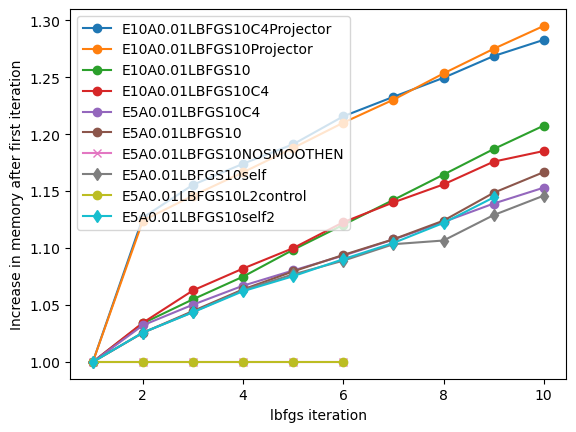

In [46]:
# filenames = ["/home/bastian/D1/registration/mrislurm/436844_log_python_srun.txt"]

path = pathlib.Path("/home/bastian/D1/registration/cubeslurm/")

# slurmids = [437139, 437140]

# slurmids += [437147, 437148]

slurmids = [437150]

slurmids += [437152, 437153]

slurmids += [437156, 437157]


path = pathlib.Path("/home/bastian/D1/registration/cubeslurm/")
slurmids = list(range(437160, 437164))

slurmids += [437178, 437179, 437193, 437202, 437207, 437212]

filenames = [path / (str(slurmid) + "_log_python_srun.txt") for slurmid in slurmids]

# filenames = ["/home/bastian/D1/registration/mrislurm/436856_log_python_srun.txt",
# "/home/bastian/D1/registration/mrislurm/436844_log_python_srun.txt"
# ]

minm, maxm = 1e16, 0
for filename in filenames:

    

    mema, outfoldername = read_memory(filename)

    outfoldername = outfoldername.replace("\n", "")
    outfoldername = outfoldername.replace(" ", "")
    print(outfoldername)
    print(mema[:, 0])

    # minm = min([np.min(mema[:, 1]), minm])

    marker = "o"

    if "self" in outfoldername:
        marker = "d"

    if "NOSMOOTHEN" in outfoldername:
        marker = "x"

    minm = None

    plt.plot(mema[:,0], mema[:,1] / mema[0,1], marker=marker, label=outfoldername)

plt.xlabel("lbfgs iteration")
plt.ylabel("Increase in memory after first iteration")
plt.legend()
plt.ylim(minm, None)
plt.show()